<a href="https://colab.research.google.com/github/mjdall/pinterest_scraper/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
efficient net paper - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficient net fine tuning - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
efficient net implementation - https://github.com/qubvel/efficientnet
transfer learning example - https://www.tensorflow.org/tutorials/images/transfer_learning
classification head - https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
image embeddings - https://rom1504.medium.com/image-embeddings-ed1b194d113e
  https://github.com/rom1504/image_embeddings/blob/master/notebooks/using_the_lib.ipynb
  https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb

"""

'\nefficient net paper - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html\nefficient net fine tuning - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/\nefficient net implementation - https://github.com/qubvel/efficientnet\ntransfer learning example - https://www.tensorflow.org/tutorials/images/transfer_learning\nclassification head - https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/\nimage embeddings - https://rom1504.medium.com/image-embeddings-ed1b194d113e\n  https://github.com/rom1504/image_embeddings/blob/master/notebooks/using_the_lib.ipynb\n  https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb\n\n'

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 1.2MB 5.6MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=e4fe76bb3d7f1b4b26fc522a66f083bb407bc9b273417d6505a3ec2cd2a70d87
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51362 sha256=d0d9b7991b447bcf3e8dff6e797bb7d59885e025b6d4a0891ddcc7747776562b
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.chdir("/content/drive/MyDrive/pinterest_scraper/")

In [ ]:
import pandas as pd

image_locs = pd.read_csv("data/image_reference.csv")
image_locs.sample(5)

,Unnamed: 0,label,file_location,group_id
5467,5467,White aesthetic,data/white_aesthetic/f0dea0f5efbf657fa98777694...,268
5640,5640,White aesthetic,data/white_aesthetic/f5bcd2d5e4eb2d10fb603e240...,441
3964,3964,Simple doodles,data/simple_doodles/422ccabc19ef257baaa80b5956...,257
2730,2730,Mens clothing styles,data/mens_clothing_styles/ddcb5b7bc7db0f1572cd...,23
2215,2215,Interior design,data/interior_design/039d25e8cb6e1fce8be9abbe9...,8


In [ ]:
def get_group(group_id, training_ids, testing_ids):
  if group_id in training_ids:
    return("training")
  elif group_id in testing_ids:
    return("testing")
  else:
    return("validation")

In [ ]:
import math
import numpy as np

TRAINING_SIZE = .7

available_labels = image_locs.label.unique().tolist()

for label in available_labels:
  label_subset = image_locs[image_locs.label == label]
  group_ids = label_subset.group_id.reset_index(drop=True)

  # get train/test/validation ids
  training_ids = group_ids.sample(frac=TRAINING_SIZE)
  remaining_ids = group_ids[~group_ids.isin(training_ids)]
  testing_ids = remaining_ids.sample(frac=.5)

  # make a lambda to apply
  alloc_lmbda = lambda gid: get_group(gid, training_ids, testing_ids)

  # write the split allocation to the df
  image_locs.loc[label_subset.index, "split"] = label_subset.group_id.apply(alloc_lmbda)

image_locs

,Unnamed: 0,label,file_location,group_id,split
0,0,90s fashion men,data/90s_fashion_men/cfaf965d69f685d8e69956ba7...,0,training
1,1,90s fashion men,data/90s_fashion_men/fa6f7f62186191520d17ec3df...,1,training
2,2,90s fashion men,data/90s_fashion_men/d9cb8bce7608cf99e01f24c98...,2,training
3,3,90s fashion men,data/90s_fashion_men/680414f948622b0203c1b0056...,3,training
4,4,90s fashion men,data/90s_fashion_men/f0cba34dd73764ef7b9962527...,4,training
...,...,...,...,...,...
5694,5694,White aesthetic,data/white_aesthetic/448946d180a5f9d9df8cbcf76...,495,training
5695,5695,White aesthetic,data/white_aesthetic/ea64d4023642884c808f6c7e7...,496,training
5696,5696,White aesthetic,data/white_aesthetic/79b0856002598d613564b80eb...,497,training
5697,5697,White aesthetic,data/white_aesthetic/7f2ec49fdd6c5928ddad23a87...,498,training


In [ ]:
image_locs.groupby("label").split.value_counts()

label                      split     
90s fashion men            training      145
                           testing        31
                           validation     31
Bullet journal             training      350
                           testing        75
                           validation     75
Easy drawings              training      350
                           testing        75
                           validation     75
Food porn                  training      350
                           testing        75
                           validation     75
Forearm tattoos            training      350
                           testing        75
                           validation     75
Interior design            training      350
                           testing        75
                           validation     75
Mens clothing styles       training      350
                           testing        75
                           validation     75
Modern farmhouse 

In [ ]:
import pathlib
import shutil
import re

def get_save_directory_name(label):
  return(re.sub(r"\s+", "_" , label.lower()))

get_file_directory = lambda file_location: str(pathlib.Path(file_location).parent) + "/"

def partition_data(image_locations):
  # get the label directory name
  image_locations["label_dir"] = image_locations.label.apply(
      get_save_directory_name)
  image_locations["filename"] = image_locations.file_location.apply(
      os.path.basename)
  label_dirs = image_locations.label_dir.unique()

  # remove current allocation of images and re-create the data directories
  data_splits = image_locations.split.unique().tolist()
  for split in data_splits:
    split_dir = f"data/{split}"
    if os.path.exists(split_dir):
      shutil.rmtree(split_dir)
    for label_dir in label_dirs:
      os.makedirs(f"{split_dir}/{label_dir}", exist_ok=True)


  # get the new path of the image
  image_locations["new_location"] = ("data/"
    + image_locations.split
    + "/"
    + image_locations.label_dir
    + "/"
    + image_locations.filename)

  # copy the image into the new directory
  for _, image_row in image_locations.iterrows():
    # todo: add progress bar here
    shutil.copy2(image_row.file_location, image_row.new_location)

# partition_data(image_locs)
# image_locs.to_csv("data/image_partitions.csv")

In [ ]:
IMG_SIZE = 224
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 64
DATASET_NAME = "pinterest"
NUM_CLASSES = image_locs.label.nunique()

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# load in the datasets
train_ds = image_dataset_from_directory("data/training", label_mode="categorical")
test_ds = image_dataset_from_directory("data/testing", label_mode="categorical")
validation_ds = image_dataset_from_directory("data/validation", label_mode="categorical")

train_ds

Found 3989 files belonging to 12 classes.
Found 855 files belonging to 12 classes.
Found 855 files belonging to 12 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 12)), types: (tf.float32, tf.float32)>

In [ ]:
import tensorflow as tf
resize_lambda = lambda image, label: (tf.image.resize(image, SIZE), label)

def preprocess_dataset(dataset, batch_size=BATCH_SIZE):
  dataset = dataset.map(resize_lambda)
  # dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return(dataset)

train_ds = preprocess_dataset(train_ds)
test_ds = preprocess_dataset(test_ds)
validation_ds = preprocess_dataset(validation_ds)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
# import matplotlib.pyplot as plt

# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))

#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)

#     augmented_image = img_augmentation(first_image)
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

IMG_SHAPE = SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")
base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

16711680/16705208 [==============================] - 1s 0us/step
(32, 7, 7, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(32, 12)


In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = img_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

27/27 [==============================] - 147s 4s/step - loss: 2.5657 - accuracy: 0.0982
initial loss: 2.57
initial accuracy: 0.10


In [ ]:
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds)

Epoch 1/10
125/125 [==============================] - 1466s 11s/step - loss: 2.3058 - accuracy: 0.2133 - val_loss: 1.8728 - val_accuracy: 0.4784
Epoch 2/10
125/125 [==============================] - 267s 2s/step - loss: 1.7693 - accuracy: 0.4783 - val_loss: 1.4619 - val_accuracy: 0.6327
Epoch 3/10
125/125 [==============================] - 267s 2s/step - loss: 1.4336 - accuracy: 0.6054 - val_loss: 1.2179 - val_accuracy: 0.6994
Epoch 4/10
125/125 [==============================] - 263s 2s/step - loss: 1.2285 - accuracy: 0.6490 - val_loss: 1.0695 - val_accuracy: 0.7216
Epoch 5/10
125/125 [==============================] - 265s 2s/step - loss: 1.1104 - accuracy: 0.6754 - val_loss: 0.9698 - val_accuracy: 0.7450
Epoch 6/10
125/125 [==============================] - 268s 2s/step - loss: 1.0008 - accuracy: 0.7029 - val_loss: 0.9024 - val_accuracy: 0.7474
Epoch 7/10
125/125 [==============================] - 268s 2s/step - loss: 0.9464 - accuracy: 0.7165 - val_loss: 0.8512 - val_accuracy: 0.75

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


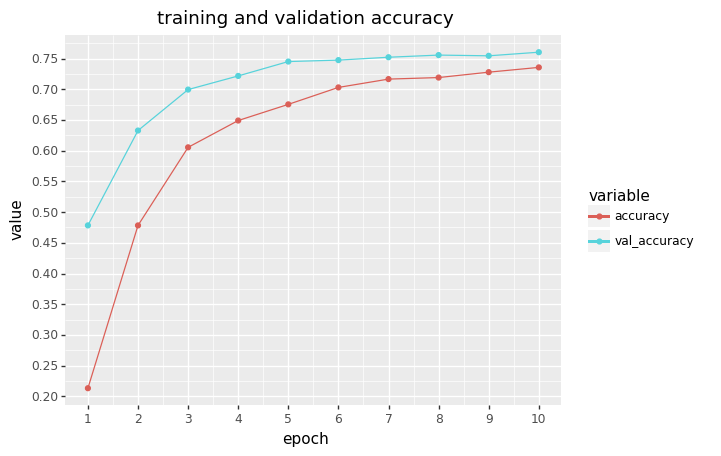

<ggplot: (8750371799853)>

In [ ]:
from plotnine import ggplot, aes, geom_line, geom_point, ggtitle, scale_x_continuous, scale_y_continuous

history_df = pd.DataFrame(history.history)
history_df["epoch"] = range(1, len(history_df.accuracy) + 1)
history_melt = history_df.melt(value_vars=["accuracy", "val_accuracy", "loss", "val_loss"], id_vars = "epoch")

accuracy_stats = history_melt[history_melt.variable.isin(["accuracy", "val_accuracy"])]
loss_stats = history_melt[history_melt.variable.isin(["loss", "val_loss"])]

(
  ggplot(accuracy_stats, aes(x = "epoch", y = "value", colour = "variable")) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks = range(12)) +
  scale_y_continuous(breaks = np.linspace(0.0, 1.0, 21)) +
  ggtitle("training and validation accuracy")
)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


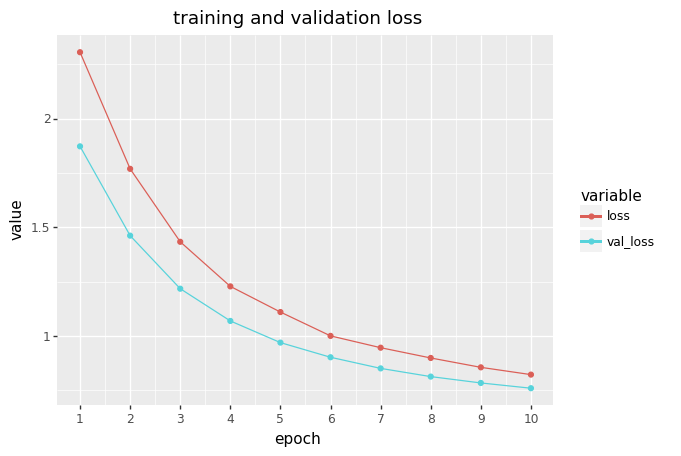

<ggplot: (8750372507165)>

In [ ]:
(
  ggplot(loss_stats, aes(x = "epoch", y = "value", colour = "variable")) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks = range(12)) +
  ggtitle("training and validation loss")
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


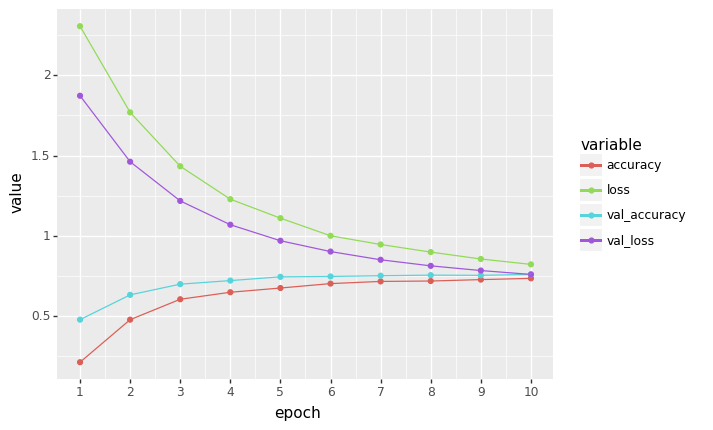

<ggplot: (8750371702209)>

In [ ]:
(
  ggplot(history_melt, aes(x = "epoch", y = "value", colour = "variable")) +
  geom_point() +
  scale_x_continuous(breaks = range(12)) +
  geom_line()
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                15372     
Total params: 4,064,943
Trainable params: 15,372
Non-trainable params: 4,049,571
______________________________________________

In [ ]:
from keras.models import Model

emb_model = Sequential(model.layers[:-2])

emb_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
def images_to_embeddings(model, dataset):
  return model.predict(dataset.flat_map(lambda image_raw, image_name: image_raw), verbose=1)

In [ ]:
test_images = [(x, y) for x, y in test_ds]
all_labels = np.concatenate([y for _, y in test_images], axis=0)
all_labels = [str(int(tf.argmax(label))) for label in all_labels]

image_embeddings = []
for (image_batch, _) in test_images:
  image_embeddings.append(emb_model.predict(image_batch))

image_embeddings = np.concatenate(image_embeddings, axis=0)
image_embeddings[0]

array([-0.11187334, -0.08148091, -0.08804222, ...,  0.17839926,
       -0.03903088, -0.11348444], dtype=float32)

In [ ]:
label_lookup = { str(i): name for i, name in enumerate(os.listdir("data/testing"))}
image_labels = [label_lookup[label] for label in all_labels]

image_labels

['90s_fashion_men',
 'food_porn',
 'bullet_journal',
 'easy_drawings',
 'simple_doodles',
 '90s_fashion_men',
 'mens_clothing_styles',
 'white_aesthetic',
 'modern_farmhouse_kitchens',
 'simple_doodles',
 'forearm_tattoos',
 'starbucks_drinks',
 'forearm_tattoos',
 'food_porn',
 'bullet_journal',
 'easy_drawings',
 'interior_design',
 'simple_doodles',
 'modern_farmhouse_kitchens',
 'modern_farmhouse_kitchens',
 'forearm_tattoos',
 'simple_doodles',
 'simple_doodles',
 'starbucks_drinks',
 'mens_clothing_styles',
 'food_porn',
 'forearm_tattoos',
 'simple_doodles',
 'mens_clothing_styles',
 'starbucks_drinks',
 'easy_drawings',
 'tattoo_sketches',
 'tattoo_sketches',
 'mens_clothing_styles',
 'interior_design',
 'food_porn',
 'mens_clothing_styles',
 '90s_fashion_men',
 'starbucks_drinks',
 'forearm_tattoos',
 'tattoo_sketches',
 'starbucks_drinks',
 'simple_doodles',
 'bullet_journal',
 'food_porn',
 'simple_doodles',
 'easy_drawings',
 'simple_doodles',
 'mens_clothing_styles',
 'mod

In [ ]:
import umap

umap_model = umap.UMAP(n_components=3)
%time umap_embeddings = umap_model.fit_transform(image_embeddings)

umap_components = pd.DataFrame({
    "component_1": umap_embeddings[:, 0],
    "component_2": umap_embeddings[:, 1],
    "component_3": umap_embeddings[:, 2],
    "class": image_labels,
})

umap_components

CPU times: user 7.06 s, sys: 165 ms, total: 7.23 s
Wall time: 5.59 s


,component_1,component_2,component_3,class
0,5.069445,0.948406,6.535965,90s_fashion_men
1,1.078743,10.978053,5.432088,food_porn
2,1.616925,11.822950,1.553549,bullet_journal
3,2.880894,11.300467,2.404254,easy_drawings
4,3.058815,12.098727,1.684233,simple_doodles
...,...,...,...,...
850,10.177214,10.985060,7.092534,interior_design
851,2.316274,12.090834,1.254983,bullet_journal
852,1.966258,13.013371,1.202546,bullet_journal
853,1.766434,5.601349,3.313697,easy_drawings


### Notes

* Embeddings are wrong, need to fix (or labels are, need to debug)

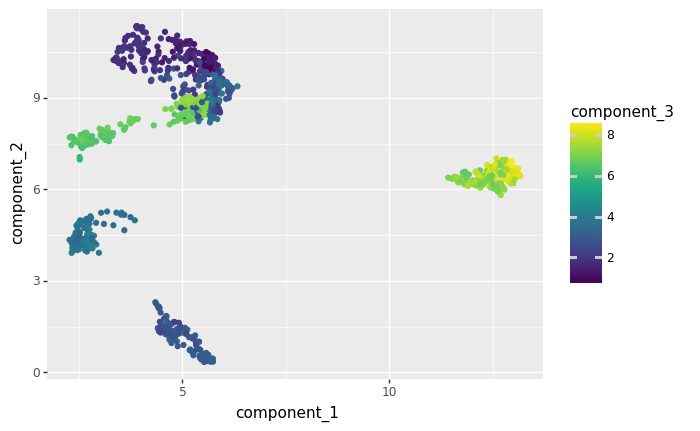

<ggplot: (8750340888789)>

In [ ]:


(
    ggplot(umap_components, aes(x = "component_1", y = "component_2", color = "component_3")) +
    geom_point()
)

In [171]:
import plotly.express as px

fig = px.scatter_3d(
    umap_components,
    x="component_1",
    y="component_2",
    z="component_3",
    color="class")

fig.update_traces(
  marker=dict(size=3),
  selector=dict(mode="markers"))

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height=780, width=1366
)

fig.show()